# Plan Enumeration Without Cartesian Products (5 Points)

Copyright Immanuel Haffner, Jens Dittrich  [Big Data Analytics Group](https://bigdata.uni-saarland.de/), [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

## Set-Up

In [1]:
from dataclasses import dataclass
import graphviz as gv
import itertools
import math
import random as rnd
import typing

## Define a Join Graph Data Structure

A join graph is a collection of named relations and joins of these relations.  The join graph implements certain sanity
checks:  (1) No two relations must have the same name.  (2) The selectivity of a join must be in the range 0 to 1
(inclusive).  (3)  The relations that a join refers to must be present in the join graph.

This class is meant to be used as a single handle to a potentially complex join graph structure.

In [2]:
class JoinGraph:
    @dataclass(eq=True, frozen=True)
    class Relation:
        name: str
        size: int

    @dataclass(eq=True, frozen=True)
    class Join:
        selectivity: float
        relation_names: typing.Tuple

    def __init__(self):
        self.named_relations = dict()
        self.joins = set()

    def add_relation(self, name, size):
        if name in self.named_relations:
            raise ValueError(f'Name "{name}" already taken')
        self.named_relations[name] = JoinGraph.Relation(name, size)

    def add_join(self, selectivity, *relation_names):
        # Make sure, all relations are present
        for tn in relation_names:
            if not tn in self.named_relations:
                raise ValueError(f'No relation with name "{tn}"')
        if not (0 <= selectivity <= 1):
            raise ValueError(f'Illegal selectivity of {selectivity}; must be in the range 0 to 1.')
        self.joins.add(JoinGraph.Join(selectivity, relation_names))

###  Define a function to draw the join graph with the graphviz tool.

In [3]:
def draw_join_graph(graph):
    G = gv.Graph(name='join_graph', comment='The Join Graph')

    # Find the minimum and maximum join selectivities in the join graph
    sel_min = sel_max = 0
    for J in graph.joins:
        sel_min = min(sel_min, J.selectivity)
        sel_max = max(sel_max, J.selectivity)

    # Add the Relations as vertices.
    for T in graph.named_relations.values():
        G.node(T.name, f'<<B>{T.name}</B><SUB><FONT POINT-SIZE="10">|·|={T.size:,}</FONT></SUB>>')

    # Add the joins as edges with their selectivity as label.
    for J in graph.joins:
        vertices = J.relation_names
        for i in range(1, len(vertices)):
            x = 1 - (J.selectivity - sel_min) / (sel_max - sel_min)
            penwidth = 3.5 * x**5 + 0.4 # compute the stroke width proportionally to the selectivity
            G.attr('edge', penwidth=str(penwidth))
            G.edge(vertices[i-1], vertices[i], label=f'{J.selectivity:f}')

    return G

### Defining a Cost Model

First we need to define a cost function to estimate the cost of a join.  We define a cost function that estimates the
cost of a join as the sum of the sizes of the two input relations, called `size_of_inputs`.  (This is similar the the
cost model of the running time of a hash join, given $c_1$ and $c_2$ are 1.)

In [4]:
class CostFunctions:
    # The cost of a join is equal to the sum of the size of all input relations.
    def size_of_inputs(size_left, size_right, selectivity):
        return size_left + size_right

In [6]:
def compute_cost(plan, graph, cost_fn):
    # Start with the first relation.
    first = plan[0]
    joined = set([first])
    size_left = graph.named_relations[first].size
    cost = 0
    # print(f'Start with relation {first} of size {size_left:,}')

    # Join each relation one after the other.
    for i in range (1, len(plan)):
        right = plan[i]

        # Combine all join predicates.  If no join predicate is applicable, the selectivity remains 1 and the join
        # degenerates to the Cartesian product.
        selectivity = 1
        for J in graph.joins:
            if right in J.relation_names and len(joined.intersection(J.relation_names)) != 0:
                selectivity *= J.selectivity

        size_right = graph.named_relations[right].size
        # print(f'Join {joined} of size {size_left} and {right} of size {size_right} with combined selectivity {selectivity:f}.')
        # Add the cost of this join to the total cost.
        cost += cost_fn(size_left, size_right, selectivity)
        # Compute the size of the new intermediate result.
        size_left = round(selectivity * size_left * size_right)
        #print(f'  --> Cost = {cost:,}, Size = {size_left:,}')
        joined.add(right)

    return cost

### A more complex join graph.

This is a join graph for the IMDb data set, extended with the cinemas relation where movies are shown.

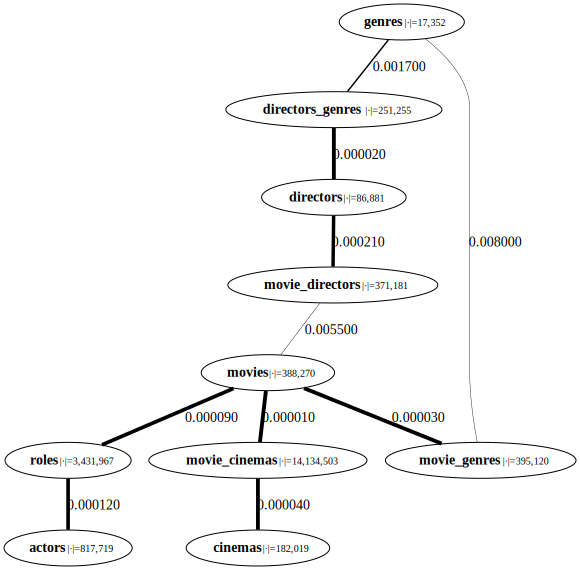

In [7]:
imdb_graph = JoinGraph()

imdb_graph.add_relation('genres', 17_352)
imdb_graph.add_relation('directors_genres', 251_255)
imdb_graph.add_relation('directors', 86_881)
imdb_graph.add_relation('movie_directors', 371_181)
imdb_graph.add_relation('movies', 388_270)
imdb_graph.add_relation('movie_genres', 395_120)
imdb_graph.add_relation('roles', 3_431_967)
imdb_graph.add_relation('actors', 817_719)
imdb_graph.add_relation('movie_cinemas', 14_134_503)
imdb_graph.add_relation('cinemas', 182_019)

imdb_graph.add_join(0.00170,  'genres', 'directors_genres')
imdb_graph.add_join(0.00002, 'directors_genres', 'directors')
imdb_graph.add_join(0.00021, 'directors', 'movie_directors')
imdb_graph.add_join(0.00550, 'movie_directors', 'movies')
imdb_graph.add_join(0.00003, 'movies', 'movie_genres')
imdb_graph.add_join(0.00800, 'movie_genres', 'genres')
imdb_graph.add_join(0.00009, 'movies', 'roles')
imdb_graph.add_join(0.00012, 'roles', 'actors')
imdb_graph.add_join(0.00001, 'movies', 'movie_cinemas')
imdb_graph.add_join(0.00004, 'movie_cinemas', 'cinemas')

draw_join_graph(imdb_graph)

In [8]:
def draw_query_plan(plan):
    G = gv.Graph(name='query_plan', comment='The Query Plan')
    G.graph_attr['rankdir'] = 'BT'

    # Add the Relations as leaves.
    for tbl in plan:
        G.node(tbl, f'<<B>{tbl}</B>>')

    # Add the joins as inner nodes.
    left = plan[0]
    for i in range(1, len(plan)):
        right = plan[i]
        G.node(str(i), '⋈')
        G.edge(left, str(i))
        G.edge(right, str(i))
        left = str(i)

    return G

## Pruning the search space
In the notebook [Plan Enumeration.ipynb](https://github.com/BigDataAnalyticsGroup/bigdataengineering/blob/master/Plan%20Enumeration.ipynb)
we have already seen how we can, for a given cost function, determine the cheapest plan by enumerating all plan alternatives for a query. Now implement the `find_cheapest_plan_with_pruning()` function, which, unlike `find_cheapest_plan_exhaustive()`, ignores plans with a Cartesian product. To do this, use the join graph passed as a parameter to decide whether a join between two relations or partial results exists. Your function should only consider 'left-deep' plans

CPU times: total: 6.08 s
Wall time: 6.35 s


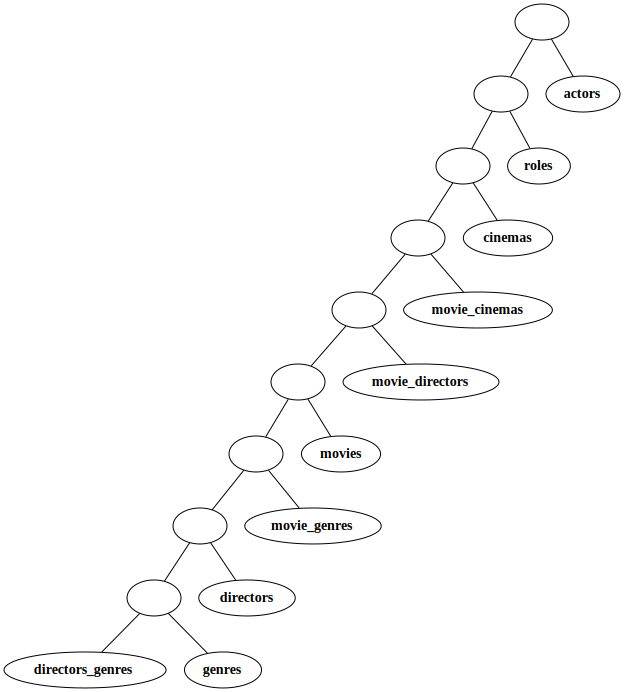

The cheapest plan is ['directors_genres', 'genres', 'directors', 'movie_genres', 'movies', 'movie_directors', 'movie_cinemas', 'cinemas', 'roles', 'actors'] with cost 64,856,523,035,553,260.


In [36]:
def find_cheapest_plan_exhaustive(join_graph, cost_fn):
    # Extract the relation names
    relations = [R.name for R in join_graph.named_relations.values()]

    least_cost = math.inf
    cheapest_plan = None

    # Consider all possible permutations (of which there are $n!$).
    for perm in itertools.permutations(relations):
        cost = compute_cost(perm, join_graph, cost_fn)
        if cost < least_cost:
            least_cost = cost
            cheapest_plan = perm

    return cheapest_plan

# def find_cheapest_plan_with_pruning(join_graph, cost_fn):
def find_cheapest_plan_with_pruning(join_graph:JoinGraph, cost_fn):

    def is_cartesian_product(relations):
        # Check if the product of relation sizes equals the total size
        # print(relations)
        total_size = sum(relation.size for relation in relations)
        product_sizes = 1
        for relation in relations:
            product_sizes *= relation.size
        return total_size != product_sizes

    # Extract the relation names
    relations = list(join_graph.named_relations.values())

    least_cost = math.inf
    cheapest_plan = None

    # Do not consider all possible permutations (of which there are $n!$)!!!
    for perm in itertools.permutations(relations):

        if is_cartesian_product(perm):
            continue

        cost = compute_cost(perm, join_graph, cost_fn)
        if cost < least_cost:
            least_cost = cost
            cheapest_plan = perm

    return cheapest_plan


%time plan = find_cheapest_plan_with_pruning(imdb_graph, CostFunctions.size_of_inputs)
# print('final plan:', plan)
plan = ['directors_genres', 'genres', 'directors', 'movie_genres', 'movies', 'movie_directors', 'movie_cinemas', 'cinemas', 'roles', 'actors']
display(draw_query_plan(plan))
cost = compute_cost(plan, imdb_graph, CostFunctions.size_of_inputs)
print(f'The cheapest plan is {plan} with cost {cost:,}.')

Below you can find a sample solution of the resulting join plan, together with the respective costs. Keep in mind that because of the symmetry, there are multiple valid plans (but not costs!).

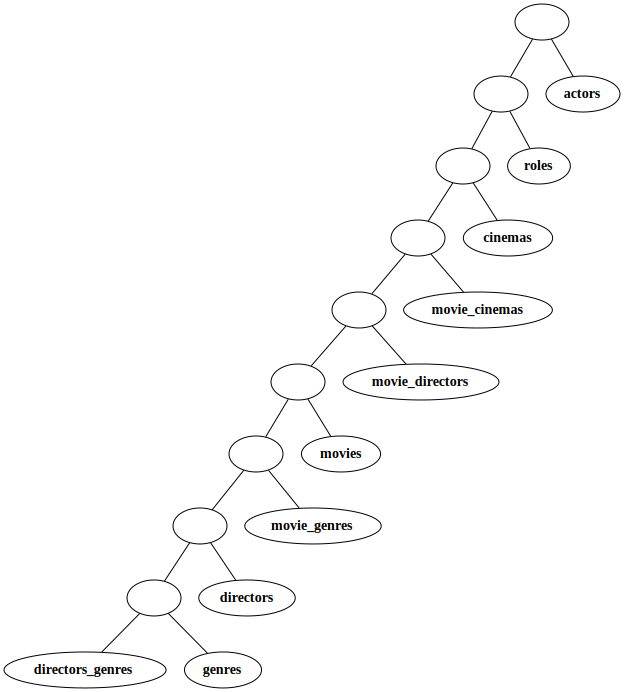

The cheapest plan is ['directors_genres', 'genres', 'directors', 'movie_genres', 'movies', 'movie_directors', 'movie_cinemas', 'cinemas', 'roles', 'actors'] with cost 64,856,523,035,553,260.


In [16]:
plan = ['directors_genres', 'genres', 'directors', 'movie_genres', 'movies', 'movie_directors', 'movie_cinemas', 'cinemas', 'roles', 'actors']
display(draw_query_plan(plan))
cost = compute_cost(plan, imdb_graph, CostFunctions.size_of_inputs)
print(f'The cheapest plan is {plan} with cost {cost:,}.')

Use the following cell to test your implementation.

In [17]:
%time plan = find_cheapest_plan_with_pruning(imdb_graph, CostFunctions.size_of_inputs)
display(draw_query_plan(plan))
cost = compute_cost(plan, imdb_graph, CostFunctions.size_of_inputs)
print(f'The cheapest plan is {plan} with cost {cost:,}.')

['genres', 'directors_genres', 'directors', 'movie_directors', 'movies', 'movie_genres', 'roles', 'actors', 'movie_cinemas', 'cinemas']
CPU times: total: 0 ns
Wall time: 0 ns


TypeError: 'NoneType' object is not iterable